In [1]:
#This is the code that we have written (in progress) to solve Homework 1 of the FRIB Theory TALENT Summer School
#This code will (when we complete it) compute scattering cross sections as a function of E and l via the partial-wave method, using the Numerov integration method to compute the scattering wavefunction
#Authors:  Chad Ummel, Heather Garland, Rajesh Ghimire, Natalia Calleya

import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import special as sp

In [2]:
#Physical constants
hbar = 197.3286 #(hbar*c in MeV fm)
mp = 938.272 #Proton mass (in MeV)
mn = 939.565 #Neutron mass (in MeV)
mu = mp*mn/(mp+mn) #Reduced mass

In [3]:
#Subroutine to define the potential and k
def potential(E,l,r0,h,nmax):

    ECM = mn/(mp+mn)*E #CM Energy (assuming proton beam)
    
    #Malfliet-Tjon potential parameters
    VA = 626.8932
    muA = 1.550
    VR = 1438.7228
    muR = 3.11

    #Construct the effective potential and k
    n = np.linspace(0,nmax+1,nmax+2)
    r = r0+n*h
    #V = np.zeros(nmax+2) #for debugging
    V = VR*np.exp(-muR*r)/r - VA*np.exp(-muA*r)/r
    Vang = l*(l+1)*(hbar**2)/(2*mu*(r**2))
    Veff = V + Vang
    ksq = 2*mu*(ECM - Veff)/(hbar**2)
    k = np.sqrt(ksq)
    
    return(ECM,r,V,Veff,k,ksq)

In [4]:
#Numerov method subroutine to compute the wavefunction
def numerov(E,l):
    
    #Numerical Integration parameters
    h = 0.05 #Step size in fm
    
    #Set starting point, r_0
    if l==0:
        r0 = 1e-8
    else:
        r0 = 2.0*l*h #Starting point for r (in fm).
        
    rmax = 20 #*math.sqrt(E) #maximum r in fm
    
    nmax = int(round((rmax-r0)/h)) #number of steps

    (ECM,r,V,Veff,k,ksq) = potential(E,l,r0,h,nmax)
    
    #Define u and set Boundary conditions
    u = [0]*nmax
    check = [0]*nmax
    u[0] = 0 #u(r=0) = 0
    u[1] = h**(l+1) #What is a good choice for this?
    u[2] = 2*u[1]-h**2*ksq[1]*u[1]

    #Compute the wavefunction using the Numerov method
    for i in range(2,nmax-1,1):
        u[i+1] = (2*(1-5/12*(h**2)*ksq[i])*u[i]-(1+1/12*(h**2)*ksq[i-1])*u[i-1])/(1+1/12*(h**2)*ksq[i+1])
        
    return(r0,h,nmax,r,Veff,k,u)

In [5]:
#Compute the phase shift using Carl's pseudo-Wronskian method
def phaseshift(E,l):
    (r0,h,nmax,r,Veff,k,u)=numerov(E,l)
    n2 = np.linspace(0,nmax-1,nmax)
    r2 = r0+n2*h
    deltal = np.arctan((u[-2]*sp.spherical_jn(l,k[-3]*r2[-1])-u[-1]*sp.spherical_jn(l,k[-4]*r2[-2]))/(u[-2]*sp.spherical_yn(l,k[-3]*r2[-1])-u[-1]*sp.spherical_yn(l,k[-4]*r2[-2])))
    if deltal<0:
        deltal = deltal+math.pi
    return(r,r2,Veff,k,u,deltal)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


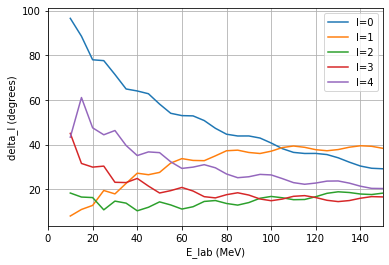

In [6]:
#Loop to plot the phase shift as a function of E and l
E = np.linspace(10,150,int((150-10)/5+1))
deltal = np.zeros(len(E))
for l in range(0,5,1):
    for i in range(0,len(E),1):
        (r,r2,Veff,k,u,deltal[i])=phaseshift(E[i],l)
    plt.plot(E,deltal/math.pi*180,label="l=%s" %l)
plt.grid()
plt.xlabel("E_lab (MeV)")
plt.ylabel("delta_l (degrees)")
plt.xlim(0,E[-1])
plt.legend();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


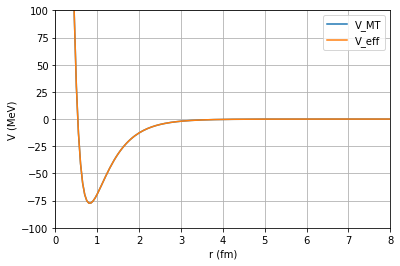

In [7]:
#Debugging cell to check V_MT and V_eff plots
E=5
l=0

#Numerical Integration parameters
h = 0.05 #Step size in fm

#Set starting point, r_0
if l==0:
    r0 = 1e-6
else:
    r0 = 2.0*l*h #Starting point for r (in fm).

nmax = 1000 #Terminate the integration after 1000 steps

(ECM,r,V,Veff,k,ksq) = potential(E,l,r0,h,nmax)
plt.grid(1)
plt.plot(r,V,label="V_MT")
plt.plot(r,Veff,label="V_eff")
plt.ylim(-100,100)
plt.xlim(0,8)
plt.xlabel('r (fm)')
plt.ylabel('V (MeV)')
plt.legend();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


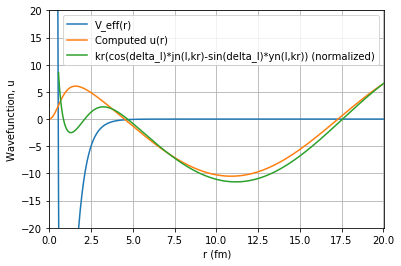

In [8]:
#Debugging cell to check plot of wavefunction against asymptotic behavior
E=5
l=0
(r,r2,Veff,k,u,deltal) = phaseshift(E,l)
asymptotic=k*r*(math.cos(deltal)*sp.spherical_jn(l,k*r)-math.sin(deltal)*sp.spherical_yn(l,k*r))
ANC = u[-1]/asymptotic[-3]
plt.plot(r,Veff,label="V_eff(r)")
plt.plot(r2,u,label="Computed u(r)")
plt.plot(r,ANC*asymptotic,label="kr(cos(delta_l)*jn(l,kr)-sin(delta_l)*yn(l,kr)) (normalized)")
plt.xlim(0,r[-1])
plt.ylim(-20,20)
plt.grid(1)
plt.xlabel('r (fm)')
plt.ylabel('Wavefunction, u');
plt.legend();